# **4. LOS LDA TEXT Vectorization**

**Turn on the High-Ram and T4 GPU at the very beginning.**

## **4.1 Setup**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
try:
  import dill
except:
  !pip install dill
  import dill
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

import spacy
try:
    nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])
except:
    from spacy.cli import download

    download("en_core_web_sm")
    nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])
!pip install xlsxwriter
!pip install fanalysis
!pip install adjustText
from fanalysis.mca import MCA
from adjustText import adjust_text
import plotly.graph_objects as go
import plotly.express as px

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.7 MB/s eta 0:00:00


In [2]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  # connect your colab with the drive
  drive.mount(mount)

 # Switch to the directory on the Google Drive that you want to use
  import os
  path_to_repo = mount + "/MyDrive/MIMIC Project/"

else:
  # Setup Repository
  with open("repo_info.txt", "r") as repo_info:
      path_to_repo = repo_info.readline()


print(path_to_repo)

path_to_data = f"{path_to_repo}data/"
# path_to_raw = f"{path_to_data}raw/"
path_to_processed = f"{path_to_data}processed/"
path_to_lda = f"{path_to_data}lda/"
# path_to_icd = f"{path_to_data}icd_codes/"
path_to_models = f"{path_to_repo}models/"
path_to_results = f"{path_to_repo}results/"
# path_to_tables = f"{path_to_repo}tables"

# os.makedirs(path_to_tables, exist_ok = True)

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/MIMIC Project/


In [ ]:
# PARAMETERS

session_seed = 42 # set seed for our session
test_proportion = 0.2

MAX_FEATURES = 10000 # maximum number of features
min_df = 5 # minimum frequency
max_df = 0.8 # maximum frequency
N_GRAM = (1,2) # n_gram range

seed_tag = f'_{session_seed}'

random.seed(session_seed)


# Set to True if we want to include deaths
death_incl = False
death_tag = np.where(death_incl,"_death", "")

## **4.2 Process Dataset**

In [ ]:
# import dataset
file = f'{path_to_processed}all_raw_data_2024{death_tag}.csv.gz'
raw_df = pd.read_csv(file, compression = 'gzip', low_memory=False)

In [ ]:
# examine the variables (names)
print(f'The original dataset has {raw_df.shape[0]} obserations, and {raw_df.shape[1]} variables. The unique key is hadm_id.')
display(raw_df.info())

The original dataset has 35268 obserations, and 63 variables. The unique key is hadm_id.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35268 entries, 0 to 35267
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hadm_id             35268 non-null  int64  
 1   subject_id          35268 non-null  int64  
 2   ethnicity           35268 non-null  object 
 3   admission_type      35268 non-null  object 
 4   admission_location  35268 non-null  object 
 5   insurance           35268 non-null  object 
 6   religion            35268 non-null  object 
 7   marital_status      35268 non-null  object 
 8   icu_los             35268 non-null  float64
 9   gender              35268 non-null  object 
 10  age                 35268 non-null  float64
 11  urea_n_min          35253 non-null  float64
 12  urea_n_max          35253 non-null  float64
 13  urea_n_mean         35253 non-null  float64
 14  platelets_min

None

In [ ]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['hadm_id', 'subject_id'])

In [ ]:
# Transform the LOS/readm_duration timedelta to days (as decimal values to increase precision)
df['los'] = pd.to_timedelta(df.los)
df['los'] = df.los/pd.to_timedelta(1, unit='D')

In [ ]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(35268, 34606)

In [ ]:
# check proportion of missing values
missing = pd.concat([df.isna().sum(), df.isna().mean()], axis = 1)
missing.columns = ['count', 'proportions']
missing.sort_values('proportions',ascending = False)

,count,proportions
patientweight,17081,0.493585
albumin_min,11147,0.322112
calcium_min,870,0.025140
magnesium_max,106,0.003063
glucose_max,104,0.003005
glucose_min,104,0.003005
glucose_mean,104,0.003005
temp_max,55,0.001589
temp_min,55,0.001589
temp_mean,55,0.001589


In [ ]:
# drop variables having more than 20 % missing values
print(f"Variables with more than 20% Missing Values: {list(missing.loc[missing.proportions >= 0.2].index)}")
df = df.drop(columns=missing.loc[missing.proportions >= 0.2].index)

Variables with more than 20% Missing Values: ['albumin_min', 'patientweight']


In [ ]:
# Impute missing values
df = df.interpolate()

# Check if there are no missing values
if df.isna().sum().sum() == 0:
    print("After imputing missing values, there are no missing values at all now.")
else:
    print("There are still missing values after imputation.")

After imputing missing values, there are no missing values at all now.


In [ ]:
# Drop subject_id and hadm_id columns before identifying variables
data_subset = df.drop(['text'], axis=1)

# Separate numerical and categorical variables
numerical_vars = data_subset.select_dtypes(include=['float64', 'int64'])
categorical_vars = data_subset.select_dtypes(include=['object'])

# Descriptive analysis of numerical variables
numerical_stats = numerical_vars.describe()
print("Descriptive statistics of numerical variables:")
print(numerical_stats)

# Unique types and counts of categorical variables
for column in categorical_vars.columns:
    unique_values = categorical_vars[column].unique()
    value_counts = categorical_vars[column].value_counts()
    print(f"Unique categories and counts of {column}:")
    print(value_counts)

Descriptive statistics of numerical variables:
            icu_los           age    urea_n_min    urea_n_max   urea_n_mean  platelets_min  \
count  34606.000000  34606.000000  34606.000000  34606.000000  34606.000000   34606.000000   
mean       4.681426     77.155254     16.646030     38.137650     26.035288     167.837904   
std        6.527507     56.695584     13.539881     28.713077     18.707766      92.660530   
min        0.001500     18.022083      0.000000      2.000000      1.421053       4.000000   
25%        1.428475     54.465229      9.000000     19.000000     13.857143     106.000000   
50%        2.536000     67.106050     13.000000     28.000000     20.000000     156.000000   
75%        4.947350     78.667379     20.000000     47.000000     31.857143     214.000000   
max      153.928000    310.280859    160.000000    290.000000    232.040000    1310.000000   

       platelets_max  platelets_mean  magnesium_max   calcium_min  resprate_min  resprate_max  \
count   3

## **4.3 Binarize LOS & Readmission Duration**

### 4.3.1 Binarize LOS

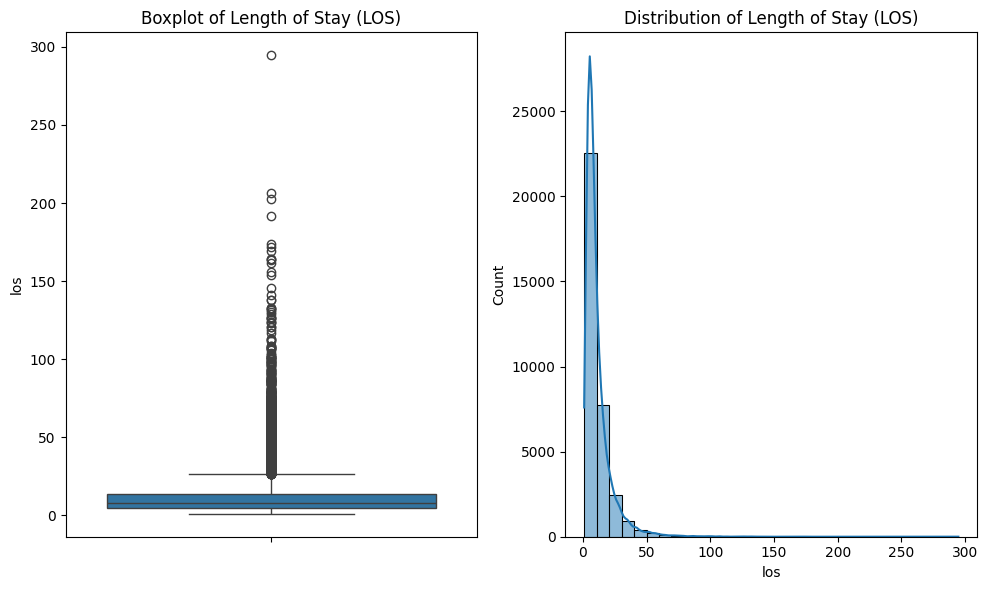

In [ ]:
# check distribution of outcome
plt.figure(figsize=(10, 6))

# Boxplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.boxplot(data=df, y='los')
plt.title('Boxplot of Length of Stay (LOS)')

# Histogram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(data=df, x='los', bins=30, kde=True)
plt.title('Distribution of Length of Stay (LOS)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Compute Lower and Upper Fence according to Tukey's criteria
Q1 = np.percentile(df['los'], 25)
Q3 = np.percentile(df['los'], 75)
IQR = Q3 - Q1
LF = Q1 - 1.5 * IQR
UF = Q3 + 1.5 * IQR

percentiles = np.arange(50, 100, 10)
for p in percentiles:
    threshold = np.percentile(df['los'], p)
    df[f'los_cat_{p}'] = df['los'] > threshold

df['los_cat_UF'] = df['los'] > UF

table_data = []

for p in percentiles:
    threshold = np.percentile(df['los'], p)
    count_values = (df[f'los_cat_{p}']).sum()
    percentage_values = (df[f'los_cat_{p}']).mean()
    table_data.append({'Variable': f'los_cat_{p}', 'Value': threshold, 'Value Counts': count_values, 'Normalized Counts': percentage_values})

count_values_UF = df['los_cat_UF'].sum()
percentage_values_UF = df['los_cat_UF'].mean()
table_data.append({'Variable': 'los_cat_UF', 'Value': UF, 'Value Counts': count_values_UF, 'Normalized Counts': percentage_values_UF})
table_df = pd.DataFrame(table_data)
print(table_df)

     Variable      Value  Value Counts  Normalized Counts
0  los_cat_50   7.989236         17303           0.500000
1  los_cat_60   9.731944         13842           0.399988
2  los_cat_70  11.951736         10382           0.300006
3  los_cat_80  15.713889          6921           0.199994
4  los_cat_90  22.899306          3461           0.100012
5  los_cat_UF  26.760156          2513           0.072617


### 4.3.2 Binarize Readmission Duration

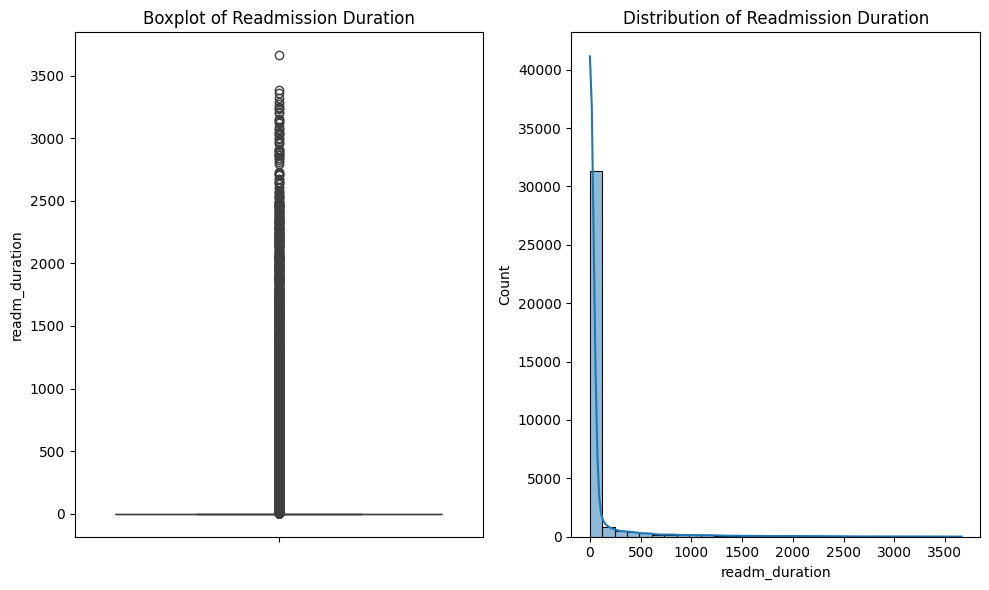

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.boxplot(data=df, y='readm_duration')
plt.title('Boxplot of Readmission Duration')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(data=df, x='readm_duration', bins=30, kde=True)
plt.title('Distribution of Readmission Duration')

plt.tight_layout()
plt.show()

In [ ]:

# Calculate the number of observations for each condition without creating new columns
num_readm_cat_3 = ((df['readm_duration'] <= 3) & (df['readmission'] == "Yes")).sum()
num_readm_cat_7 = ((df['readm_duration'] <= 7) & (df['readmission'] == "Yes")).sum()
num_readm_cat_30 = ((df['readm_duration'] <= 30) & (df['readmission'] == "Yes")).sum()
# Print the results
print("Number of observations with readmission <= 3 days:", num_readm_cat_3)
print("Number of observations with readmission <= 7 days:", num_readm_cat_7)
print("Number of observations with readmission <= 30 days:", num_readm_cat_30)
print("The number of readmission within 3 or 7 days are too small in our dataset, so we only create readmission within30 days binary variable")

Number of observations with readmission <= 3 days: 2
Number of observations with readmission <= 7 days: 71
Number of observations with readmission <= 30 days: 1066
The number of readmission within 3 or 7 days are too small in our dataset, so we only create readmission within30 days binary variable


In [ ]:
# create binary variables readm_cat where prolonged readmission is any value greater than cutting points, 3 days, 7 days, 30 days
df['readm_cat_30'] = (df['readm_duration'] <= 30) & (df['readmission'] == "Yes")
df['readm_cat_365'] = (df['readm_duration'] <= 365) & (df['readmission'] == "Yes")

value_counts = df['readm_cat_30'].value_counts()
normalized_counts = df['readm_cat_30'].value_counts(normalize=True)
counts_df = pd.concat([value_counts, normalized_counts], axis=1)
counts_df.columns = ['Value Counts', 'Normalized Counts']
counts_df.index.name = 'readm_cat_30'
display(counts_df)

value_counts2 = df['readm_cat_365'].value_counts()
normalized_counts2 = df['readm_cat_365'].value_counts(normalize=True)
counts_df2 = pd.concat([value_counts2, normalized_counts2], axis=1)
counts_df2.columns = ['Value Counts', 'Normalized Counts']
counts_df2.index.name = 'readm_cat_365'

display(counts_df2)

,Value Counts,Normalized Counts
readm_cat_30,,
False,33540,0.969196
True,1066,0.030804


,Value Counts,Normalized Counts
readm_cat_365,,
False,30384,0.877998
True,4222,0.122002


### 4.3.3 Binarization Mortality

In [ ]:
categorical_vars = ['ethnicity', 'admission_type', 'admission_location', 'insurance', 'religion', 'marital_status', 'gender', 'age_cat', 'type_stay', 'prev_adm', 'dest_discharge',
                    'emergency_dpt', 'icd_chapter', 'origin_patient', 'drg_severity', 'drg_mortality', 'comorbidity', 'readmission', 'to_icu',
                    'los_cat_UF', 'los_cat_50', 'los_cat_60', 'los_cat_70', 'los_cat_80', 'los_cat_90', 'readm_cat_30']
death_distribution = pd.DataFrame(columns=['Categorical Variable', 'Category', 'Deaths'])

for var in categorical_vars:
    death_counts = df.groupby(var)['mortality'].sum().reset_index()
    death_counts.columns = ['Category', 'Deaths']

    fig = px.bar(death_counts, x='Category', y='Deaths', title=f'Distribution of Death for {var}',
                 labels={'Category': var, 'Deaths': 'Number of Deaths'},
                 hover_data={'Deaths': True}, color='Deaths')

    fig.update_layout(xaxis_title=var, yaxis_title='Number of Deaths', showlegend=False)
    fig.show()

## 4.5 Create final dataset

In [ ]:
df_2024 = df.drop(columns=['los_cat_60', 'los_cat_70', 'los_cat_90'])
# df_2024.to_excel('/content/gdrive/MyDrive/MIMIC.xlsx', index=False, encoding='utf-8')
df_2024.columns

## **4.6 Heavier Preprocessing & BoW - Define Functions**

In [ ]:
stemmer = SnowballStemmer("english", ignore_stopwords=True) # we initialize our stemmer
stop_words = stopwords.words('english') # nltk stopwords
lemmatizer = WordNetLemmatizer() # lemmatizer in case we want to lemmatize instead of stemming

In [ ]:
def remove_stopwords(text): # delete stopwords from text
    text =  " ".join([x for x in text.split()if x not in stop_words])
    return text

def heading_clean(text):
    text = re.sub(r'\[\*\*(.+?)\*\*\]', "", text) # we take out information in brackets
    text = re.sub(r'(Admission Date:)|(Discharge Date:)|(Date of Birth:)|(Name:)|(Unit No:)', "", text, flags = re.I)
    if preproc_heavier:
        text = re.sub(r'Sex:', "", text, flags = re.I)
        text = text.lower() # lowercase text
        text = unidecode((text))
        text = re.sub(r'[^\w\s]','',text)
        if lemmatize == True:
            if use_spacy == True:
                doc = nlp(text)
                text = " ".join([token.lemma_ for token in doc])
            else:
                text =  " ".join([lemmatizer.lemmatize(x) for x in text.split()])
        else:
            text =  " ".join([stemmer.stem(x) for x in text.split()])
        text = remove_stopwords(text)
    return text

In [ ]:
def vectorize_to_dataframe(df, vectorizer_obj):
    """
    Function to return a dataframe from our vectorizer results
    """
    df = pd.DataFrame(data = df.toarray(), columns = vectorizer_obj.get_feature_names_out())
    return df

In [ ]:
def vectorize_features(X_train, X_test, method = 'frequency'):
    """
    Function to perform vectorization of our test sets
    X_train, X_test, X_val: our dataframes
    method: either 'frequency', 'tf_idf', 'onehot' to employ a different BoW technique
    """
    # initialize our vectorizer
    if method == 'tf_idf':
        vectorizer = TfidfVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES)
    elif method == 'frequency':
        vectorizer = CountVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES)
    elif method == 'onehot':
        vectorizer = CountVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES, binary = True)

    train_text = vectorizer.fit_transform(X_train.text)
    train_text = vectorize_to_dataframe(train_text, vectorizer)
    test_text = vectorizer.transform(X_test.text)
    test_text = vectorize_to_dataframe(test_text, vectorizer)
    return train_text, test_text

In [ ]:
def save_dataframes(train, test, method, target = False):
    """
    Function to save our dataframes
    train: train set to be saved
    method: method through which we have processed the dataframes, needed as save keyword
    test: test set to be saved
    """
    # need to reset the index
    train.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    train.to_feather('{}{}train_{}{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag, death_tag))
    # need to reset the index
    test.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    test.to_feather('{}{}test_{}{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag, death_tag))

In [ ]:
def load_datasets(method):
    """
    Function to load train, test and validation set based on the chosen method
    method: string for the processing method we want to load
    """
    global path_to_processed
    # load it back
    train = pd.read_feather('{}{}train_{}{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag, death_tag))
    test = pd.read_feather('{}{}test_{}{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag, death_tag))
    return train, test

## **4.7 Length of Stay(LOS) Cutting points**

## **4.8 In Hospital Mortality**

## 4.9 Readmission within 30 days

In [ ]:
# 1. Vectorization Loop# 1. Vectorization Loop
# Iterate over our main methods of vectorization
vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}


for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

    if preprocessing:
        try:
            df = df_2024.drop(['icu_los', 'prev_adm', 'readmission', 'readm_duration', 'los_cat_UF', 'los_cat_50', 'los_cat_80', 'mortality'], axis=1)
            df['text'] = df.text.apply(lambda x: heading_clean(x))
            # need to reset the index
            df.reset_index(inplace=True, drop = True)
            # save our dataset up to now in feather format
            df.to_feather(f'{path_to_processed}df_readm_30_{preproc_tag}{lemma_tag}{death_tag}')
            print('Dataframe Saved')
        except:
            df = pd.read_feather(f'{path_to_processed}df_readm_30_{preproc_tag}{lemma_tag}{death_tag}')
            print('Dataframe Loaded')
        train, test = train_test_split(df, train_size=0.80, stratify = df['readm_cat_30'], random_state=42)
    # perform vectorization
    method_list = ['frequency', 'onehot','tf_idf']
    train_clean = train.drop(columns = 'text')
    train_clean.reset_index(inplace = True, drop = True)
    test_clean = test.drop(columns = 'text')
    test_clean.reset_index(inplace = True, drop = True)
    for method in method_list:
        print(method)
        # for each method we perform vectorization
        train_text, test_text = vectorize_features(train, test, method = method)
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_text], axis=1)
        X_test = pd.concat([test_clean, test_text], axis=1)
        X_train = X_train.loc[:, ~X_train.columns.duplicated()] # added by shiqing
        X_test = X_test.loc[:, ~X_test.columns.duplicated()] # added by shiqing
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        # and save the dataframes
        save_dataframes(X_train, X_test, method = method)
        # And also perform LDA
        try:
            with open(f'{path_to_lda}lda_readm_30_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'rb') as file: # and save the fitted model,    # add _readm_30_
                lda = dill.load(file)
            train_lda = lda.transform(train_text)
        except:
            lda = LatentDirichletAllocation(n_components = 300, random_state = session_seed, n_jobs = -1)
            train_lda = lda.fit_transform(train_text)
        train_lda = pd.DataFrame(train_lda)
        train_lda.columns=["F"+str(i) for i in range(0, len(train_lda.columns))]
        test_lda = lda.transform(test_text)
        test_lda = pd.DataFrame(test_lda)
        test_lda.columns=["F"+str(i) for i in range(0, len(test_lda.columns))]
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_lda], axis = 1)
        X_test = pd.concat([test_clean, test_lda], axis = 1)
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        save_dataframes(X_train, X_test, method = f'lda_readm_30_{method}')                                                                             # add readm_30_
        with open(f'{path_to_lda}lda_readm_30_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'wb') as file: # and save the fitted model,       # add _readm_30_
            dill.dump(lda, file)


print("---------------------------------------------------------------------")
X_train.shape, X_test.shape

stemming
Dataframe Saved
frequency
onehot
tf_idf
spacy
Dataframe Saved
frequency
onehot
tf_idf
---------------------------------------------------------------------


((27684, 355), (6922, 355))

In [ ]:
# 2. Save Topic-Words combination
# We now want to export for each LDA model the corresponding words in an excel file

vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}

for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

    # List of BoW methods
    method_list = ['frequency', 'tf_idf', 'onehot']

    # Initialize an excel writer where we are going to save all the various word-topic for each method
    writer = pd.ExcelWriter(f'{path_to_lda}output_lda_readm_30_{key}{death_tag}.xlsx')                                                                 # add readm_30_

    # Iterate over all 3 methods
    for method in method_list:

        # Re-Load our LDA model
        with open(f'{path_to_lda}lda_readm_30_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'rb') as file: # and save the fitted model,      # add _readm_30_
            lda = dill.load(file)

        # Load the datasets constructed with the BOW method
        _, test = load_datasets(method)

        # Get the words - and remove the placeholder "dischargetext_"
        # text_col = [re.sub("dischargetext_", "",col) for col in test.columns if "dischargetext" in col] # we don't have columns starts with "dischargetext" so it returns an empyty dataset
        text_col = test.columns[:10000].to_list() # I keep first 10000 columns from test dataset, added by shiqing

        # Create a pandas dataframe out of the LDA components
        lda_components = pd.DataFrame(lda.components_, columns = text_col, index = [f"F{i}" for i in range(0, 300)]).T

        # Create a sheet for our current method
        workbook=writer.book
        worksheet=workbook.add_worksheet(f'{method}')
        writer.sheets[f'{method}'] = worksheet

        lda_components.to_excel(writer,sheet_name=f'{method}')
    # Close the excel workbook
    writer.close()

print("Save Topic-Words combination for Readmission 30 Days Done!")

stemming
spacy
Save Topic-Words combination for Readmission 30 Days Done!


## 4.10 Readmission within 365 days

In [ ]:
# 1. Vectorization Loop# 1. Vectorization Loop
# Iterate over our main methods of vectorization
vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}


for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

    if preprocessing:
        try:
            df = df_2024.drop(['icu_los', 'prev_adm', 'readmission', 'readm_duration', 'los_cat_UF', 'los_cat_50', 'los_cat_80', 'mortality','readm_cat_30'], axis=1)
            df['text'] = df.text.apply(lambda x: heading_clean(x))
            # need to reset the index
            df.reset_index(inplace=True, drop = True)
            # save our dataset up to now in feather format
            df.to_feather(f'{path_to_processed}df_readm_365_{preproc_tag}{lemma_tag}{death_tag}')
            print('Dataframe Saved')
        except:
            df = pd.read_feather(f'{path_to_processed}df_readm_365_{preproc_tag}{lemma_tag}{death_tag}')
            print('Dataframe Loaded')
        train, test = train_test_split(df, train_size=0.80, stratify = df['readm_cat_365'], random_state=42)
    # perform vectorization
    method_list = ['frequency', 'onehot','tf_idf']
    train_clean = train.drop(columns = 'text')
    train_clean.reset_index(inplace = True, drop = True)
    test_clean = test.drop(columns = 'text')
    test_clean.reset_index(inplace = True, drop = True)
    for method in method_list:
        print(method)
        # for each method we perform vectorization
        train_text, test_text = vectorize_features(train, test, method = method)
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_text], axis=1)
        X_test = pd.concat([test_clean, test_text], axis=1)
        X_train = X_train.loc[:, ~X_train.columns.duplicated()] # added by shiqing
        X_test = X_test.loc[:, ~X_test.columns.duplicated()] # added by shiqing
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        # and save the dataframes
        save_dataframes(X_train, X_test, method = method)
        # And also perform LDA
        try:
            with open(f'{path_to_lda}lda_readm_365_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'rb') as file: # and save the fitted model,    # add _readm_30_
                lda = dill.load(file)
            train_lda = lda.transform(train_text)
        except:
            lda = LatentDirichletAllocation(n_components = 300, random_state = session_seed, n_jobs = -1)
            train_lda = lda.fit_transform(train_text)
        train_lda = pd.DataFrame(train_lda)
        train_lda.columns=["F"+str(i) for i in range(0, len(train_lda.columns))]
        test_lda = lda.transform(test_text)
        test_lda = pd.DataFrame(test_lda)
        test_lda.columns=["F"+str(i) for i in range(0, len(test_lda.columns))]
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_lda], axis = 1)
        X_test = pd.concat([test_clean, test_lda], axis = 1)
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        save_dataframes(X_train, X_test, method = f'lda_readm_365_{method}')                                                                             # add readm_30_
        with open(f'{path_to_lda}lda_readm_365_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'wb') as file: # and save the fitted model,       # add _readm_30_
            dill.dump(lda, file)


print("---------------------------------------------------------------------")
X_train.shape, X_test.shape

stemming
Dataframe Saved
frequency
onehot
tf_idf
spacy
Dataframe Saved
frequency
onehot
tf_idf
---------------------------------------------------------------------


((27684, 354), (6922, 354))

In [ ]:
# 2. Save Topic-Words combination
# We now want to export for each LDA model the corresponding words in an excel file

vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}

for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

    # List of BoW methods
    method_list = ['frequency', 'tf_idf', 'onehot']

    # Initialize an excel writer where we are going to save all the various word-topic for each method
    writer = pd.ExcelWriter(f'{path_to_lda}output_lda_readm_365_{key}{death_tag}.xlsx')                                                                 # add readm_30_

    # Iterate over all 3 methods
    for method in method_list:

        # Re-Load our LDA model
        with open(f'{path_to_lda}lda_readm_365_{seed_tag}{method}{preproc_tag}{lemma_tag}{death_tag}', 'rb') as file: # and save the fitted model,      # add _readm_30_
            lda = dill.load(file)

        # Load the datasets constructed with the BOW method
        _, test = load_datasets(method)

        # Get the words - and remove the placeholder "dischargetext_"
        # text_col = [re.sub("dischargetext_", "",col) for col in test.columns if "dischargetext" in col] # we don't have columns starts with "dischargetext" so it returns an empyty dataset
        text_col = test.columns[:10000].to_list() # I keep first 10000 columns from test dataset, added by shiqing

        # Create a pandas dataframe out of the LDA components
        lda_components = pd.DataFrame(lda.components_, columns = text_col, index = [f"F{i}" for i in range(0, 300)]).T

        # Create a sheet for our current method
        workbook=writer.book
        worksheet=workbook.add_worksheet(f'{method}')
        writer.sheets[f'{method}'] = worksheet

        lda_components.to_excel(writer,sheet_name=f'{method}')
    # Close the excel workbook
    writer.close()

print("Save Topic-Words combination for Readmission 365 Days Done!")

stemming
spacy
Save Topic-Words combination for Readmission 365 Days Done!


In [ ]:
train.columns

Index(['ethnicity', 'admission_type', 'admission_location', 'insurance', 'religion',
       'marital_status', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max', 'calcium_min',
       'resprate_min', 'resprate_max', 'resprate_mean', 'glucose_min', 'glucose_max',
       'glucose_mean', 'hr_min', 'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max', 'temp_mean', 'sapsii',
       'sofa', 'urine_min', 'urine_mean', 'urine_max', 'age_cat', 'type_stay', 'dest_discharge',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los', 'text', 'drg_severity',
       'drg_mortality', 'comorbidity', 'first_trans_dur', 'count_transfer', 'icustay_count',
       'to_icu', 'readm_cat_365'],
      dtype='object')